In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['font.serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

import re

In [2]:
sample = 'S1824'
workdir = '/mnt/hpc/home/xuxinran/4C/UMI4C/date/dongqing_1101/umi4cpackage/workdir/example.S1824_1_PTPN1'
primer_specificity = 1.01

In [3]:
## parse the 3C stats
threec_stats_path = f'{workdir}/3C_stats.txt'

with open(threec_stats_path, 'r') as f:
    threec_stats = f.readlines()
    threec_stats = ''.join(threec_stats)

threec_stats = threec_stats.replace('(', '').replace(')', '')
overall_mapping = re.findall(r'overall fragments mapped: (\d+.\d+)%', threec_stats)[0]
overall_mapping = float(overall_mapping)
unique_mapping = re.findall(r'unique mapped fragments: (\d+.\d+)%', threec_stats)[0]
unique_mapping = float(unique_mapping)
undigested = re.findall(r'undigested or self-ligated frags: \d+ (\d+.\d+)%', threec_stats)[0]
undigested = float(undigested)

n_umis = re.findall(r'total complexity\t(\d+)', threec_stats)[0]

ith = 0
with open(threec_stats_path, 'r') as f:
    for line in f:
        ith += 1
        if line.startswith('---fragment coverage'):
            line_frag = ith
        if line.startswith('---cis decay'):
            line_cis = ith


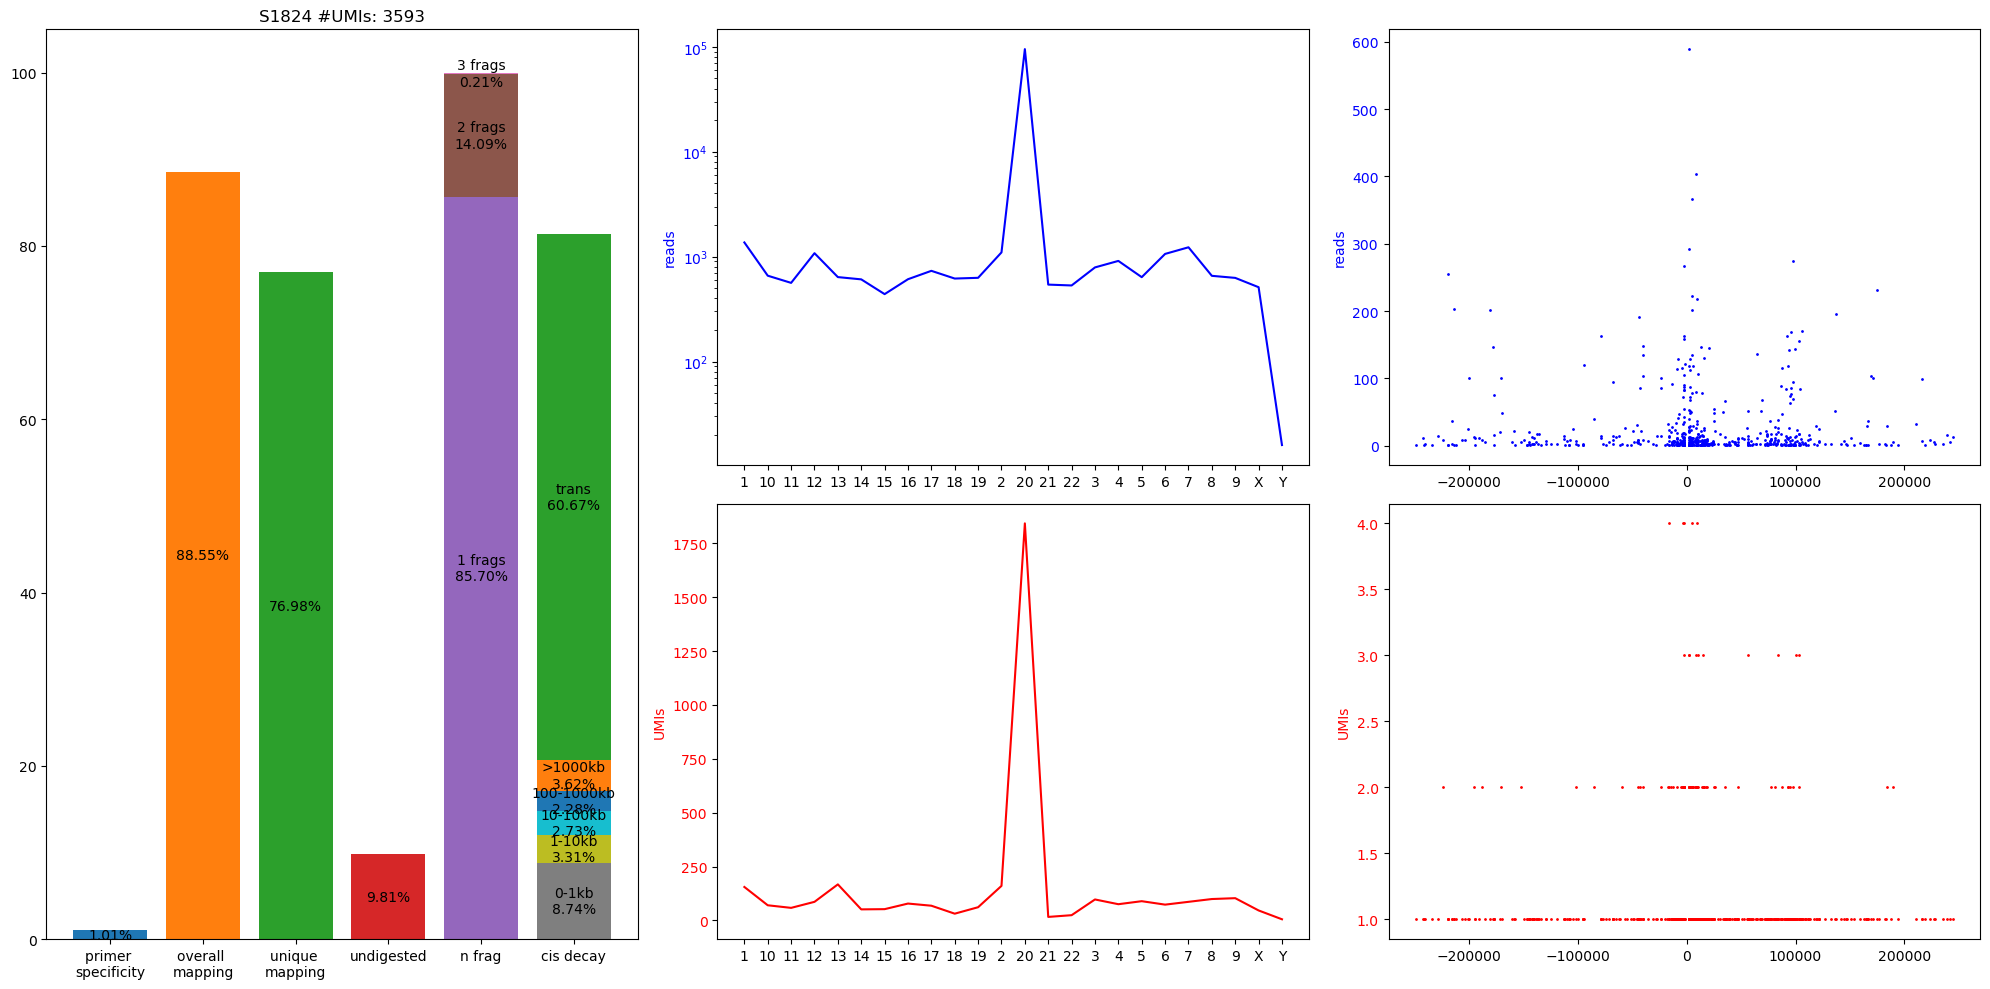

In [6]:
fig = plt.figure(tight_layout=True, figsize=(20,10))
gs = gridspec.GridSpec(2, 3)

ax = fig.add_subplot(gs[:, 0])
frag_df = pd.read_csv(
    threec_stats_path, sep="\t", skiprows=line_frag, nrows=line_cis - line_frag - 3
)
frag_df["count"] = frag_df["num_reads(%)"].str.extract(r"(\d+)").astype(int)
frag_df["prec"] = frag_df["num_reads(%)"].str.extract(r"(\d+\.\d+)").astype(float)

decay_df = pd.read_csv(
    threec_stats_path, sep="\t", skiprows=line_cis, nrows=ith - line_cis - 3
)
decay_df["count"] = decay_df["molecules_in_bin"].str.extract(r"(\d+)").astype(int)
decay_df["prec"] = decay_df["molecules_in_bin"].str.extract(r"(\d+\.\d+)").astype(float)

frag_df['bottom'] = frag_df['prec'].cumsum().shift().fillna(0)
# fig, ax = plt.subplots(figsize=(6,8))
# primer specificity
ax.bar(0, primer_specificity)
ax.text(
    0,
    primer_specificity / 2,
    f"{primer_specificity:.2f}%",
    ha="center",
    va="center",
)
# overall mapping
ax.bar(1, overall_mapping)
ax.text(
    1,
    overall_mapping / 2,
    f"{overall_mapping:.2f}%",
    ha="center",
    va="center",
)
# unique mapping
ax.bar(2, unique_mapping)
ax.text(
    2,
    unique_mapping / 2,
    f"{unique_mapping:.2f}%",
    ha="center",
    va="center",
)
# undigested
ax.bar(3, undigested)
ax.text(
    3,
    undigested / 2,
    f"{undigested:.2f}%",
    ha="center",
    va="center",
)

frag_df["bottom"] = frag_df["prec"].cumsum().shift().fillna(0)
for i in frag_df.index:
    ax.bar(4, frag_df.loc[i, "prec"], bottom=frag_df.loc[i, "bottom"])
    ax.text(
        4,
        frag_df.loc[i, "prec"] / 2 + frag_df.loc[i, "bottom"],
        f"{i+1} frags\n{frag_df.loc[i, 'prec']:.2f}%",
        ha="center",
        va="center",
    )

decay_df["bottom"] = decay_df["prec"].cumsum().shift().fillna(0)
for i in decay_df.index:
    ax.bar(5, decay_df.loc[i, "prec"], bottom=decay_df.loc[i, "bottom"])
    ax.text(
        5,
        decay_df.loc[i, "prec"] / 2 + decay_df.loc[i, "bottom"],
        f"{decay_df.loc[i, 'bin']}\n{decay_df.loc[i, 'prec']:.2f}%",
        ha="center",
        va="center",
    )

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(
    [
        "primer \nspecificity",
        "overall \nmapping",
        "unique \nmapping",
        "undigested",
        "n frag",
        "cis decay",
    ]
)
ax.set_title(f"{sample} #UMIs: {n_umis}")

adj_full_path = f'{workdir}/adj.full.coord'
adj_full = pd.read_csv(adj_full_path, sep="\t")
vp_chr, vp_pos = adj_full['chr1'].mode()[0], adj_full['start1'].mode()[0]

ax = fig.add_subplot(gs[0, 1])
ax.plot(adj_full.groupby('chr2').agg('reads').sum(), color='blue', label='reads')
ax.set_yscale('log')
ax.set_ylabel('reads', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax = fig.add_subplot(gs[1, 1])
ax.plot(adj_full.groupby('chr2').agg('mol').sum(), color='red', label='umi')
ax.set_ylabel('UMIs', color='red')
ax.tick_params(axis='y', labelcolor='red')

vp_adj_full = adj_full[adj_full['chr1']==vp_chr].copy()
vp_adj_full['start2'] = vp_adj_full['start2'] - vp_pos
vp_adj_full = vp_adj_full[(vp_adj_full['start2'] > -250000) & (vp_adj_full['start2'] < 250000)]
vp_adj_full = vp_adj_full[~((vp_adj_full['start2'] > -1500) & (vp_adj_full['start2'] < 1500))]
# vp_adj_full = vp_adj_full[vp_adj_full['reads']>=10]
vp_adj_full.index = vp_adj_full['start2'].values
vp_adj_full = vp_adj_full.sort_index()
ax = fig.add_subplot(gs[0, 2])
ax.scatter(x=vp_adj_full['reads'].index, y=vp_adj_full['reads'].values, color='blue', s=1)
ax.set_ylabel('reads', color='blue')
ax.tick_params(axis='y', labelcolor='blue')
ax = fig.add_subplot(gs[1, 2])
ax.scatter(x=vp_adj_full['mol'].index, y=vp_adj_full['mol'].values, color='red', s=1)
ax.set_ylabel('UMIs', color='red')
ax.tick_params(axis='y', labelcolor='red')